In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import statsmodels.formula.api as smf
from fixedeffect.fe import fixedeffect, did, getfe


In [391]:
data = pd.read_csv('pset2.csv')

In [392]:
data['log_fatal_per_cap'] = np.log(data['fatalities']/data['population'])



#some data "cleaning"
data['years_post_prim'] = data['year']
df = pd.DataFrame(columns = data.columns)
data['never_treat'] = 0
for s in sorted(list(set(list(data['state'])))):
    x = 0
    dat = data[data['state']==s]
    for y in list(set(list(data['year']))):
        if dat.iloc[22]['primary']== 0:
            dat['years_post_prim'] = dat['years_post_prim'] - 2004
            #print(dat['years_post_prim'])
            df = df.append(dat)
            break
        if dat.iloc[x]['primary']==1:
            dat['years_post_prim'] = dat['years_post_prim'] - y
            dat['never_treat'] = 1
            df = df.append(dat)
            break
        x = x+1
           
df['post'] = df['years_post_prim']
orig = list(set(list(df['years_post_prim'])))
new = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

df['post'] = df['post'].replace(orig,new)

#assign cohort
df['cohort'] = df['state']
for s in sorted(list(set(list(data_no_treat['state'])))):
    df['cohort'] = df['cohort'].replace(s, str(df[(df['state']==s)&(df['years_post_prim']==0)]['year'].sum()))
df['cohortc'] = df['cohort']
for y in list(set(list(df['cohort']))):
    if (int(y)!=0)&(int(y) < 1990):
        df['cohortc'] = df['cohortc'].replace(y, '1980')
    if (int(y)>=1990)&(int(y)<2000):
        df['cohortc'] = df['cohortc'].replace(y, '1990')
    if int(y) =='0':
        df['cohortc'] = df['cohortc'].replace(y, '0')
    if int(y)>=2000:
        df['cohortc'] = df['cohortc'].replace(y, '2000')

<ipython-input-392-abc6be094378>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat['years_post_prim'] = dat['years_post_prim'] - y
<ipython-input-392-abc6be094378>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat['never_treat'] = 1
<ipython-input-392-abc6be094378>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

In [393]:
#1

tau_list=[]
cohort_size = []
for year in list(set(list(data['year'])))[1:]:
    dat = df[df['year']==year]
    dat2 = df[df['year']== year-1]
    
    mean_treat = dat[dat['years_post_prim']==0]['log_fatal_per_cap'].mean()
    mean_no_treat = dat[dat['years_post_prim']<0]['log_fatal_per_cap'].mean()
    mean_treat2 = dat2[dat2['years_post_prim']==-1]['log_fatal_per_cap'].mean()
    mean_no_treat2 = dat2[dat2['years_post_prim']<-1]['log_fatal_per_cap'].mean()
    
    tau = mean_treat - mean_treat2 -mean_no_treat +mean_no_treat2

    cohort = dat[dat['years_post_prim']==0]['log_fatal_per_cap'].shape[0] 
    cohort_size = dat[dat['years_post_prim']<0]['log_fatal_per_cap'].shape[0] + cohort
    tau_list.append((tau, cohort, cohort_size))
    
tau_list = [tau for tau in tau_list if str(tau[0]) != 'nan']
print(tau_list)

[(-0.019374693419648148, 1, 48), (-0.10405106982486512, 4, 47), (-0.04644978030617852, 1, 43), (-0.1317145516344156, 1, 42), (-0.010687478133418082, 1, 41), (0.03747439095362326, 2, 40), (-0.008891234326839026, 3, 38), (-0.02545566577520031, 3, 35), (-0.026686766476580415, 1, 32), (0.13967986498427098, 1, 31)]


In [438]:
tau_weighted = 0
total = 0
for tau in tau_list:
    total = total + tau[1]
    tau_weighted = tau_weighted + (tau[0]*tau[1])/tau[2]
print('dCDH ATT horizon 0')
print(tau_weighted)

dCDH ATT horizon 0
-0.01107430161452777


In [436]:
#2

data_no_treat = df[df['years_post_prim']<0]
x1 = pd.get_dummies(data_no_treat['state'])
x2 = pd.get_dummies(data_no_treat['year'])
data_no = pd.concat([data_no_treat, x1, x2], axis=1)

x3 = sorted(list(set(list(data_no_treat['state']))))[1:]
x4 = sorted(list(set(list(data_no_treat['year']))))[1:]


vals = sm.OLS(data_no['log_fatal_per_cap'], sm.add_constant(data_no[x3+x4]))
out = vals.fit(cov_type = 'HC0')
#print(out.params)
#print(out.summary())

x1 = pd.get_dummies(df['state'])
x2 = pd.get_dummies(df['year'])
df4 = pd.concat([df, x1, x2], axis=1)
data2 = df4[df4['years_post_prim']>-1]

data2['new'] = out.predict(sm.add_constant(data2[x3+x4]))
#print(data['new'])

data2['tai_i_t'] = data2['log_fatal_per_cap'] - data2['new']

print('ATT')
print(data2['tai_i_t'].mean())
print('horizon 0 ATT')
print(data2[data2['years_post_prim']==0]['tai_i_t'].mean())

#standard errors

#get cohort averages
data2['tau_i_t_c'] = data2['cohortc']
for item in list(set(list(data2['cohortc']))):
    data2['tau_i_t_c'] = data2['tau_i_t_c'].replace(item, data2[data2['cohortc']==item]['tai_i_t'].mean())

#get errors
data2['ep_i_t'] = (data2['tai_i_t'] - data2['tau_i_t_c'])/182


#sum over time
data2['ep_i'] = data2['state']
for y in list(set(list(data2['state']))):
    data2['ep_i'] = data2['ep_i'].replace(y, (data2[data2['state']==y]['ep_i_t'].sum())**2)

#sum over state

print('ATT SE')
print(np.sqrt(sum(list(set(list(data2['ep_i']))))))    



ATT
-0.10751347368607912
horizon 0 ATT
-0.05352726184482127
ATT SE
0.0325445029646265


<ipython-input-436-885a076a56e9>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['new'] = out.predict(sm.add_constant(data2[x3+x4]))
<ipython-input-436-885a076a56e9>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['tai_i_t'] = data2['log_fatal_per_cap'] - data2['new']
<ipython-input-436-885a076a56e9>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [440]:
#3

data_no_treat = df[df['years_post_prim']<0]
x1 = pd.get_dummies(data_no_treat['state'])
x2 = pd.get_dummies(data_no_treat['year'])
data_no = pd.concat([data_no_treat, x1, x2], axis=1)

x3 = sorted(list(set(list(data_no_treat['state']))))[1:]
x4 = sorted(list(set(list(data_no_treat['year']))))[1:]


vals = sm.WLS(data_no['log_fatal_per_cap'], sm.add_constant(data_no[x3+x4]), weights= data_no['population'])
out = vals.fit(cov_type = 'HC0')
#print(out.params)
#print(out.summary())

x1 = pd.get_dummies(df['state'])
x2 = pd.get_dummies(df['year'])
df4 = pd.concat([df, x1, x2], axis=1)
data2 = df4[df4['years_post_prim']>-1]

data2['new'] = out.predict(sm.add_constant(data2[x3+x4]))
#print(data['new'])

data2['tai_i_t'] = data2['log_fatal_per_cap'] - data2['new']


print(data2['tai_i_t'].mean())
print(data2[data2['years_post_prim']==0]['tai_i_t'].mean())

#standard errors

#get cohort averages
data2['tau_i_t_c'] = data2['cohortc']
for item in list(set(list(data2['cohortc']))):
    data2['tau_i_t_c'] = data2['tau_i_t_c'].replace(item, data2[data2['cohortc']==item]['tai_i_t'].mean())

#get errors
data2['ep_i_t'] = (data2['tai_i_t'] - data2['tau_i_t_c'])/182


#sum over time
data2['ep_i'] = data2['state']
for y in list(set(list(data2['state']))):
    data2['ep_i'] = data2['ep_i'].replace(y, (data2[data2['state']==y]['ep_i_t'].sum())**2)

#sum over state

print('ATT SE')
print(np.sqrt(sum(list(set(list(data2['ep_i']))))))    


-0.09775911178488182
-0.04887688449106025
ATT SE
0.03256503550586368


<ipython-input-440-b680ed32ace2>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['new'] = out.predict(sm.add_constant(data2[x3+x4]))
<ipython-input-440-b680ed32ace2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['tai_i_t'] = data2['log_fatal_per_cap'] - data2['new']
<ipython-input-440-b680ed32ace2>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [447]:
#3

data_no_treat = df[df['years_post_prim']<0]
x1 = pd.get_dummies(data_no_treat['state'])
x2 = pd.get_dummies(data_no_treat['year'])
data_no = pd.concat([data_no_treat, x1, x2], axis=1)

x3 = sorted(list(set(list(data_no_treat['state']))))[1:]
x4 = sorted(list(set(list(data_no_treat['year']))))[1:]


vals = sm.OLS(data_no['log_fatal_per_cap'], sm.add_constant(data_no[x3+x4]))
out = vals.fit(cov_type = 'HC0')
#print(out.params)
#print(out.summary())

x1 = pd.get_dummies(df['state'])
x2 = pd.get_dummies(df['year'])
df4 = pd.concat([df, x1, x2], axis=1)
data2 = df4[df4['years_post_prim']>-1]

data2['new'] = out.predict(sm.add_constant(data2[x3+x4]))
#print(data['new'])

data2['totalpop'] = data2['year']
for year in list(set(list(df['year']))):
    data2['totalpop'] = data2['totalpop'].replace(year, data2[data2['year']==year]['population'].sum())


data2['tai_i_t'] = data2['log_fatal_per_cap'] - data2['new']

data2['tau_i_t_w'] = (data2['tai_i_t'].astype(float)*data2['population'].astype(float))/data2['population'].sum().astype(float)



print(data2['tau_i_t_w'].sum())
print(data2[data2['years_post_prim']==0]['tau_i_t_w'].sum())

#standard errors

#get cohort averages
data2['tau_i_t_c'] = data2['cohortc']
for item in list(set(list(data2['cohortc']))):
    data2['tau_i_t_c'] = data2['tau_i_t_c'].replace(item, data2[data2['cohortc']==item]['tai_i_t'].mean())

#get errors
data2['ep_i_t'] = (data2['tau_i_t_w'] - data2['tau_i_t_c'])*data2['population'].astype(float)/data2['population'].sum()


#sum over time
data2['ep_i'] = data2['state']
for y in list(set(list(data2['state']))):
    data2['ep_i'] = data2['ep_i'].replace(y, (data2[data2['state']==y]['ep_i_t'].sum())**2)

#sum over state

print('ATT SE')
print(np.sqrt(sum(list(set(list(data2['ep_i']))))))   


-0.15104521999457338
-0.00671929428795754
ATT SE
0.04108397924274009


<ipython-input-447-808a1b2d673a>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['new'] = out.predict(sm.add_constant(data2[x3+x4]))
<ipython-input-447-808a1b2d673a>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['totalpop'] = data2['year']
<ipython-input-447-808a1b2d673a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [448]:
#4

data_no_treat = df[df['years_post_prim']<0]
x1 = pd.get_dummies(data_no_treat['state'])
x2 = pd.get_dummies(data_no_treat['year'])
data_no = pd.concat([data_no_treat, x1, x2], axis=1)

stateyr = []
for state in list(set(list(data_no_treat['state']))):
    data_no[state +'t'] = data_no[state]*data_no['years_post_prim']
    stateyr.append(state +'t')



x3 = sorted(list(set(list(data_no_treat['state']))))[1:]
x4 = sorted(list(set(list(data_no_treat['year']))))[1:]
x5 = sorted(stateyr)[1:]


vals = sm.OLS(data_no['log_fatal_per_cap'], sm.add_constant(data_no[x3+x4+x5].astype(float)))
out = vals.fit(cov_type = 'HC0')
#print(out.params)
#print(out.summary())

x1 = pd.get_dummies(df['state'])
x2 = pd.get_dummies(df['year'])
df4 = pd.concat([df, x1, x2], axis=1)
data2 = df4[df4['years_post_prim']>-1]
stateyr = []
for state in list(set(list(df['state']))):
    data2[state +'t'] = data2[state]*data2['years_post_prim']
    stateyr.append(state +'t')
x5 = sorted(stateyr)[1:]

data2['new'] = out.predict(sm.add_constant(data2[x3+x4+x5]))
#print(data['new'])

data2['totalpop'] = data2['year']
for year in list(set(list(df['year']))):
    data2['totalpop'] = data2['totalpop'].replace(year, data2[data2['year']==year]['population'].sum())


data2['tai_i_t'] = data2['log_fatal_per_cap'] - data2['new']


print(data2['tai_i_t'].mean())
print(data2[data2['years_post_prim']==0]['tai_i_t'].mean())

#standard errors

#get cohort averages
data2['tau_i_t_c'] = data2['cohortc']
for item in list(set(list(data2['cohortc']))):
    data2['tau_i_t_c'] = data2['tau_i_t_c'].replace(item, data2[data2['cohortc']==item]['tai_i_t'].mean())

#get errors
data2['ep_i_t'] = (data2['tai_i_t'] - data2['tau_i_t_c'])/182


#sum over time
data2['ep_i'] = data2['state']
for y in list(set(list(data2['state']))):
    data2['ep_i'] = data2['ep_i'].replace(y, (data2[data2['state']==y]['ep_i_t'].sum())**2)

#sum over state

print('ATT SE')
print(np.sqrt(sum(list(set(list(data2['ep_i']))))))    


-0.05057753337971345
-0.045391931764159184
ATT SE
0.06597909245692794


<ipython-input-448-36f95baca9d7>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2[state +'t'] = data2[state]*data2['years_post_prim']
<ipython-input-448-36f95baca9d7>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['new'] = out.predict(sm.add_constant(data2[x3+x4+x5]))
<ipython-input-448-36f95baca9d7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [443]:
#5

data_no_treat = df[df['years_post_prim']<0]
x1 = pd.get_dummies(data_no_treat['state'])
x2 = pd.get_dummies(data_no_treat['year'])
data_no = pd.concat([data_no_treat, x1, x2], axis=1)

x3 = sorted(list(set(list(data_no_treat['state']))))[1:]
x4 = sorted(list(set(list(data_no_treat['year']))))[1:]

covars = ['college', 'beer', 'totalvmt', 'precip', 'snow32', 'rural_speed', 'urban_speed']


vals = sm.OLS(data_no['log_fatal_per_cap'], sm.add_constant(data_no[x3+x4+covars].astype(float)))
out = vals.fit(cov_type = 'HC0')
#print(out.params)
#print(out.summary())

x1 = pd.get_dummies(df['state'])
x2 = pd.get_dummies(df['year'])
df4 = pd.concat([df, x1, x2], axis=1)
data2 = df4[df4['years_post_prim']>-1]

data2['new'] = out.predict(sm.add_constant(data2[x3+x4+covars]))
#print(data['new'])

data2['tai_i_t'] = data2['log_fatal_per_cap'] - data2['new']

print(data2['tai_i_t'].mean())
print(data2[data2['years_post_prim']==0]['tai_i_t'].mean())

#standard errors

#get cohort averages
data2['tau_i_t_c'] = data2['cohortc']
for item in list(set(list(data2['cohortc']))):
    data2['tau_i_t_c'] = data2['tau_i_t_c'].replace(item, data2[data2['cohortc']==item]['tai_i_t'].mean())

#get errors
data2['ep_i_t'] = (data2['tai_i_t'] - data2['tau_i_t_c'])/182


#sum over time
data2['ep_i'] = data2['state']
for y in list(set(list(data2['state']))):
    data2['ep_i'] = data2['ep_i'].replace(y, (data2[data2['state']==y]['ep_i_t'].sum())**2)

#sum over state

print('ATT SE')
print(np.sqrt(sum(list(set(list(data2['ep_i']))))))    


-0.09471218805245032
-0.05278908016271547
ATT SE
0.028004304510763234


<ipython-input-443-8bb6e6823750>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['new'] = out.predict(sm.add_constant(data2[x3+x4+covars]))
<ipython-input-443-8bb6e6823750>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['tai_i_t'] = data2['log_fatal_per_cap'] - data2['new']
<ipython-input-443-8bb6e6823750>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [472]:
data_no_treat = df[df['years_post_prim']<0]
x1 = pd.get_dummies(df['state'])
x2 = pd.get_dummies(df['year'])
data_no = pd.concat([df, x1, x2], axis=1)


x3 = sorted(list(set(list(df['state']))))[1:]
x4 = sorted(list(set(list(df['year']))))[1:]
x5 = ['primary']


vals = sm.OLS(data_no['primary'].astype(float), sm.add_constant(data_no[x3+x4].astype(float)))
out = vals.fit(cov_type = 'HC0')
#print(out.summary())

data_no['predict_prim'] = out.predict(sm.add_constant(data_no[x3+x4].astype(float)))
'''print(data_no['predict_prim'].describe())'''
data_no['primres'] = data_no['primary'] - data_no['predict_prim']
'''print(data_no['primres'].mean())
plt.hist(data_no['primres'], bins = 20)'''

denom = (data_no['primres']**2).sum()
print(denom)
data_no['w_i_t'] = data_no['primres']/denom
print(data_no['w_i_t'].describe())
print(data_no[data_no['primary']==1]['w_i_t'].sum())
print(data_no[data_no['primary']==1]['w_i_t'].mean())
print(data_no[data_no['primary']==1]['w_i_t'].std())
print(data_no[data_no['primary']==1]['w_i_t'].min())

for y in list(set(list))

56.27536231884074
count     1104.000000
unique    1004.000000
top          0.002929
freq         3.000000
Name: w_i_t, dtype: float64
1.0000000000000087
0.005494505494505542
0.003624545586484759
-0.0014164305949006784


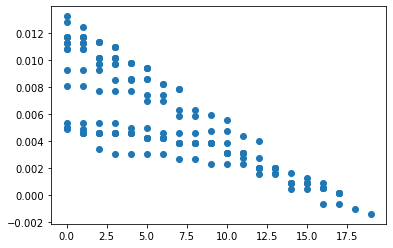

In [477]:
plt.scatter(data_no[data_no['primary']==1]['years_post_prim'],data_no[data_no['primary']==1]['w_i_t'])

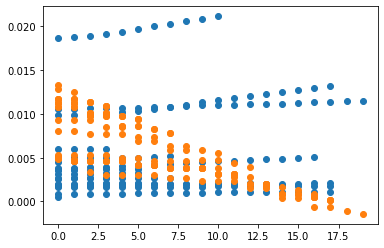

In [483]:
data_no['weights'] = data_no['population']/data_no[data_no['primary']==1]['population'].sum()
plt.scatter(data_no[data_no['primary']==1]['years_post_prim'], data_no[data_no['primary']==1]['weights'])
plt.scatter(data_no[data_no['primary']==1]['years_post_prim'],data_no[data_no['primary']==1]['w_i_t'])

In [485]:
data_no_treat = df[df['years_post_prim']<0]
x1 = pd.get_dummies(df['state'])
x2 = pd.get_dummies(df['year'])
data_no = pd.concat([df, x1, x2], axis=1)


x3 = sorted(list(set(list(df['state']))))[1:]
x4 = sorted(list(set(list(df['year']))))[1:]
x5 = ['primary']

vals = sm.OLS(data_no['log_fatal_per_cap'].astype(float), sm.add_constant(data_no[x3+x4+x5].astype(float)))
out = vals.fit(cov_type = 'HC0')
print(out.summary())

                            OLS Regression Results                            
Dep. Variable:      log_fatal_per_cap   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     195.2
Date:                Sun, 29 Oct 2023   Prob (F-statistic):               0.00
Time:                        12:58:28   Log-Likelihood:                 944.13
No. Observations:                1104   AIC:                            -1746.
Df Residuals:                    1033   BIC:                            -1391.
Df Model:                          70                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1528      0.035    -33.395      0.0